### Structured Light

TODO

In [1]:
# ipython configuration (reloads source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%matplotlib inline

import os, sys
import numpy as np
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../..'))

import slmsuite.holography.lcos_toolbox as lcos_toolbox
from slmsuite.hardware.slms.santec import Santec
from slmsuite.hardware.slms.screen_mirrored import ScreenMirrored

mpl.rc('image', cmap='twilight')

In [2]:
Santec.info();

display_number, display_name
#,  Name
1,  SB220Q,ACR,06AB,50341080
2,  LCOS-SLM,SOC,8001,2018021001
3,  Thorlabs SLM,THO,9212,007
4,  Thorlabs SLM,THO,9212,007
5,  Thorlabs SLM,THO,9212,007
6,  Thorlabs SLM,THO,9212,007
7,  Thorlabs SLM,THO,9212,007


In [3]:
ScreenMirrored.info();

Starting wx... success
display_number, (x, y, w, h)
#,  Geometry
0,  (0, 0, 1920, 1080)
1,  (-1920, 0, 1920, 1200)
2,  (1920, 0, 1920, 1200)


In [4]:
# Load SLM
slm2 = Santec(slm_number=1, display_number=2, wav_um=.780)

Santec initializing... success
Looking for display... success
Opening LCOS-SLM,SOC,8001,2018021001... success


In [5]:
# Load SLM
slm1 = ScreenMirrored(display_number=2, dx_um=8, dy_um=8, wav_design_um=1.064, wav_um=.780)

Starting wx... success


In [6]:
def plot_phase(interpolation='none'):
    fig, axs = plt.subplots(1, 2, figsize=(20,5))

    im = axs[0].imshow(np.mod(slm.phase, 2*np.pi), interpolation=interpolation)
    axs[0].set_title('slm.phase')
    fig.colorbar(im, ax=axs[0])

    im = axs[1].imshow(slm.display, interpolation=interpolation)
    axs[1].set_title('slm.display')
    fig.colorbar(im, ax=axs[1])

    plt.show()

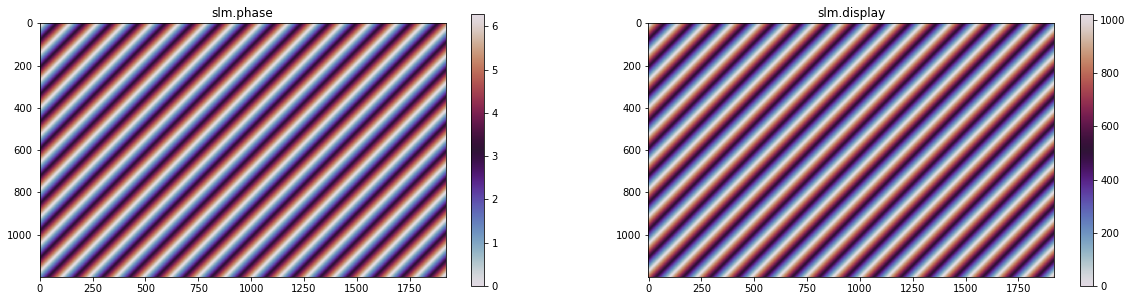

In [63]:
slm.write(lcos_toolbox.blaze(slm, vector=[.0005,.0005]))

plot_phase()

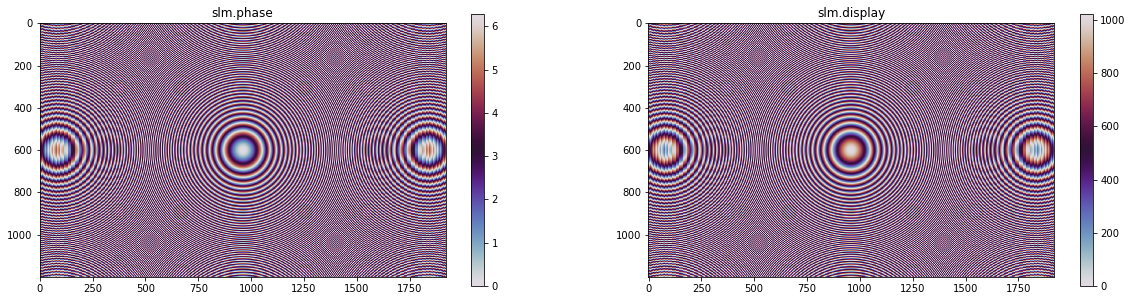

In [54]:
lens = lcos_toolbox.lens((slm.x_grid, slm.y_grid), f=1e6)

slm.write(lens)

plot_phase()

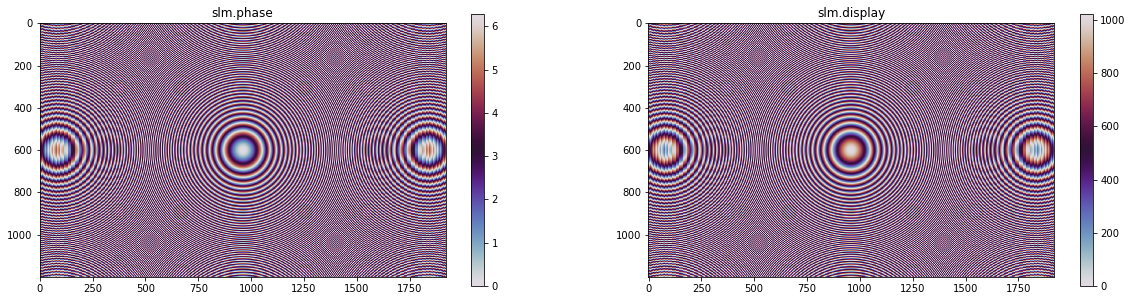

In [55]:
lens = lcos_toolbox.lens(slm, f=1e6)

slm.write(lens)

plot_phase()

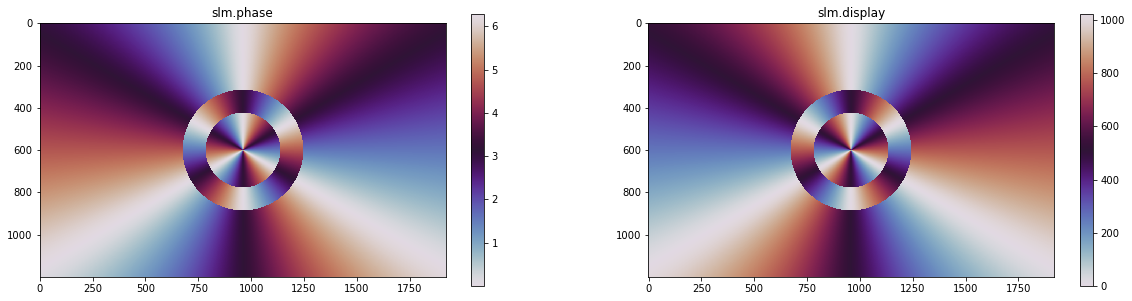

In [59]:
lg = lcos_toolbox.laguerre_gaussian(slm, l=3, p=2)

slm.write(lg)

plot_phase()

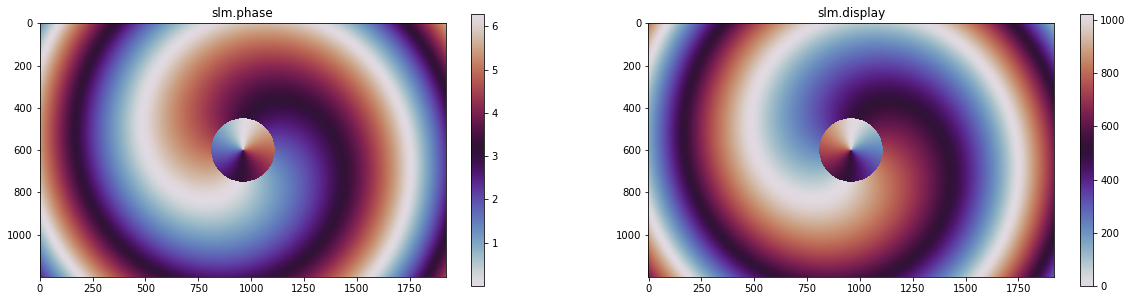

In [65]:
lg = lcos_toolbox.laguerre_gaussian(slm, l=1, p=1)
lens = lcos_toolbox.lens(slm, f=1e8)

slm.write(lg + lens)

plot_phase()

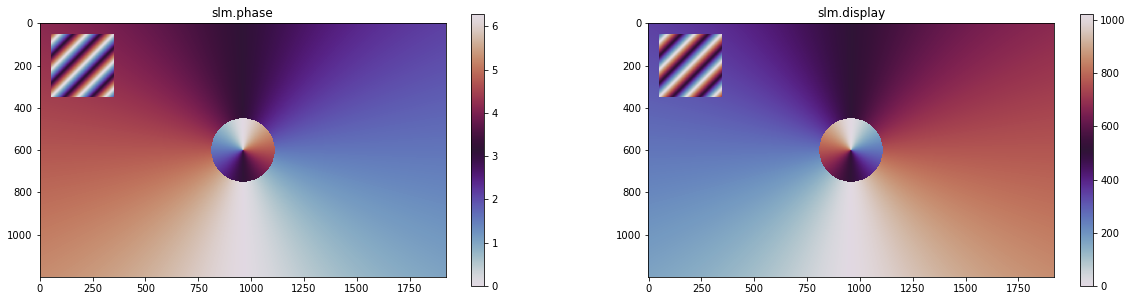

In [78]:
phase = lcos_toolbox.laguerre_gaussian(slm, l=1, p=1)

lcos_toolbox.imprint(phase, [200, 300, 200, 300], slm, lcos_toolbox.blaze, vector=[.0005, .0005], centered=True)

slm.write(phase)

plot_phase()

In [9]:
from scipy.spatial import Voronoi, voronoi_plot_2d

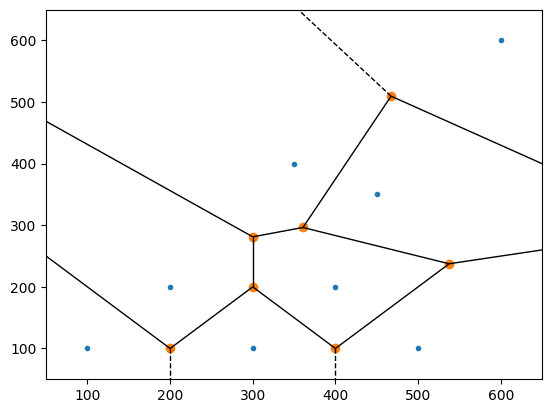

In [10]:
x_list = [100, 200, 300, 350, 400, 450, 500, 600]
y_list = [100, 200, 100, 400, 200, 350, 100, 600]

points = np.vstack((x_list, y_list)).T

vor = Voronoi(points, furthest_site=False)

fig = voronoi_plot_2d(vor)
plt.show()

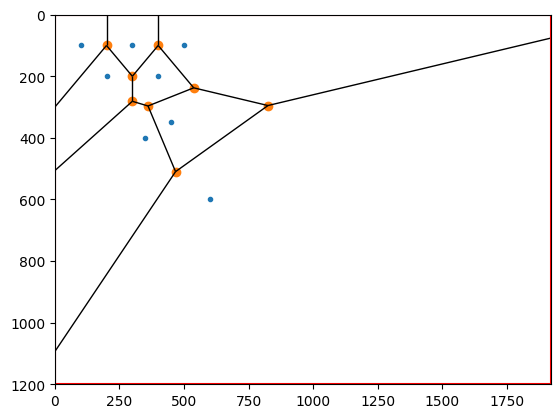

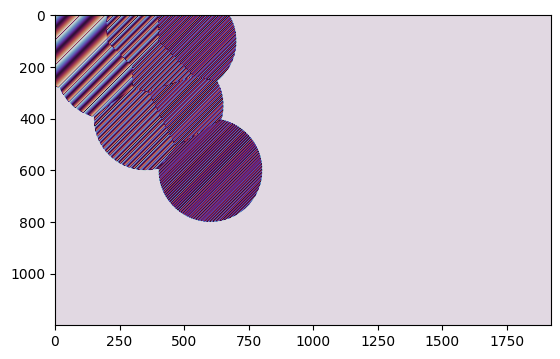

In [29]:
def voronoi_slm(points, shape, radius=200):
    hsx = shape[1]/2
    hsy = shape[0]/2

    N = np.shape(points)[0]

    points_extended = np.concatenate((np.array(points), np.array([ [hsx, -3*hsy], [hsx, 5*hsy], [-3*hsx, hsy], [5*hsx, hsy] ])))

    vor = Voronoi(points_extended, furthest_site=False)

    sx = shape[1]
    sy = shape[0]
    fig = voronoi_plot_2d(vor)
    plt.plot(   np.array([0, sx, sx, 0, 0]),
                np.array([0, 0, sy, sy, 0]), 'r')
    plt.xlim(0, sx)
    plt.ylim(sy, 0)
    plt.show()

    filled_regions = []

    for x in range(N):
        point = vor.points[x]
        region = vor.regions[vor.point_region[x]]
        pts = vor.vertices[region].astype(np.int32)

        canvas1 = np.zeros(shape, dtype=np.uint8)
        cv2.fillConvexPoly(canvas1, pts, 255, cv2.LINE_4)

        canvas2 = np.zeros(shape, dtype=np.uint8)
        cv2.circle(canvas2, tuple(point.astype(np.int32)), radius, 255, -1)

        filled_region = (canvas1 > 0) & (canvas2 > 0)

        # plt.imshow(filled_region, cmap='viridis')
        # plt.show()

        filled_regions.append(filled_region)

    return filled_regions

def test():
    shape = slm1.shape
    filled_regions = voronoi_slm(points, shape)
    N = np.shape(points)[0]
    canvas = np.zeros(shape, dtype=np.float32)

    for x in range(N):
        lcos_toolbox.imprint(canvas, filled_regions[x], slm1, lcos_toolbox.blaze, vector=[x*.001 + .001, x*.001 + .001])

    # Tested to be slightly faster than the above with pre-cached lists.
    # for x in range(N):
    #     indices = np.array(np.where(filled_regions[x]))
    #     lcos_toolbox.imprint(canvas, (indices[0], indices[1]), slm1, lcos_toolbox.blaze, vector=[x*.0001 + .0001, x*.0001 + .0001], clip=False)

    plt.imshow(np.mod(canvas, 2*np.pi))
    plt.show()

test()
# %lprun -f test test()
# %lprun -f lcos_toolbox.imprint test()